# Five ways to use Regular Expressions for  NLP

## Leverage Domain Knoweledge


Our biggest advantage as humans is that we know things about our data the machine doesn't. Regular expressions offer us an oportunity to feed that knoweledge to the machine, freeing it to learn things we haven't noticed or can't express easily. Every problem in NLP is different, but we can almost always find some patterns in the text that will give us grounding and leverage to get to the next step, and regular expressions are a great way to take advantage of that. 

## What Hurts Reddit ? 

Reddit is a place where the internet goes to seek advice and share experiences. We want to know what ailments the fine folks of Reddit are suffering from. There are many more diseases and subreddits than we could possbily enumerate, not to mention that people will often vary their spelling, so  a simple keyword search won't get us to far. Running off a few ailments in our head we notice that many of them end with **osis** or **nia** such as scoli**osis** , endometri**osis**, psych**osis**, trichotilloma**nia** or dermatillom**ania**.

We can take advantage of this observation by crafting a regular expression that searches for "long words" that end in **osis** or **ania**. Such a regex would look like this
```
([a-z]{5,}(?:(?:ania)|osis))
```
Which is a concise way of saying "Any sequence of 5 or more letters followed by either **ania** or **osis**. 

While this is super useful, if we think about it we'll probably get a lot of results that aren't very helpful. For intance Transylv**ania**, Wrestle**mania** and [matthew**matosis**](https://twitter.com/matthewmatosis?lang=en) (A youtube celeb). To get around this problem, we can use a bit more of our domain expertise. People on Reddit (and in general) will talk about the afflictions they have, and so we can expect to find those diseases mentioned with a possive word preceeding them. For instance "She doesn't have endometri**osis**" vs "I went to Wrestle**mania**".  
With that knoweledge in mind, we can expand our Regex to search for long words ending in **ania** or **osis** that are preceded by possesive words such as **have**, **has**, **had** or **with**. That regex looks like this
```
(((have)|(has)|(had)|(with)) ([a-z]{5,}((ania)|osis)))
```

Now that we have a regex that captures our domain knoweledge, let's see how we can use it at scale




## Use Your Database

Regular expresions are ubiqiuous, you can find them in you shell, text editor and in your database. The fact that regular expressions are availble in almost every database is particularly exciting, because your data probably lives in a database of some sorts. This means that we can use regular expressions to apply our domain knoweledge, and join that knoweledge with other information that resides in our database.

To illustrate this point, we'll look at the the [Reddit Comments Dataset](https://bigquery.cloud.google.com/dataset/fh-bigquery:reddit_comments?pli=1) availble on Google Bigquery. We'll use the regex we wrote in the previous section, along with some SQL, to find mentions of diseases by subreddit. 

### The Query
The SQL query we'll run in Bigquery is
```sql

SELECT
  subreddit,
  (REGEXP_EXTRACT   (body,r'(?:(?:(?:have)|(?:has)|(?:had)|(?:with)) ([a-z]{5,}(?:(?:ania)|osis)))') )
  as word,
  count(1)  c
FROM
  [fh-bigquery:reddit_comments.all]
WHERE
  
   (REGEXP_MATCH   (body,r'(?:(?:(?:have)|(?:has)|(?:had)|(?:with)) ([a-z]{5,}(?:(?:ania)|osis)))') )
   

group by  subreddit,word
order by c desc

```

Which will give us a long list of all words matching our regex, and their frequency in comments in each subreddit. 
### A Few Caveats
Three things to notice here
* I've added a bunch of **?:** to the regex. This makes the groups inside the regex non-capturing, but have no effect on the meaning of the regex
* This query will only return the first match of the regex in a string, so we aren't getting everything in the data
* There are many diseases that match our query. That's ok, as long we rememebr that what we are doing is surfacing things that come easily, not surfacing everything we can. 

### The Results

The output of these query runs a few tens of thousands of rows. You can get the data **here** but here are a few interesting insights we can pull out 
1. **endometriosis** seems to concern many women, it is twice as prominent as the next most talked about diease (tuberculosis). 
2. We can show which subreddits talk about which diseases. For example what diseases or asked about frequently or mentioned in response to an AskX subreddit
![Alt text](./askGraph.gv.svg)




## Don't be scared of post processing

Regular expressions are amazingly powerful, but sometimes they don't give us exactly what we want. Many developers spend countless hours writing convoluted regex and debugging them, because of the assumption that the regex should solve the entire problem. That assumption is not written anywhere, and you are free to post proceses the results of your regex in whatever way you see fit. 

### Cleaning Trailing White Spaces

To give an example, consider a naive regex that captures named entities. To make this regex, we'll use our knoweledge of English, and notice that named entities tend to be proper nouns and so their first letter is usually  capitalized. A regex that captures words starting with a capital letter is
```
\b[A-Z][a-z]+\b
```
To capture just the named entity, without the whitespaces, we can wrap the letters in a capturing group like so: 
```
\b([A-Z][a-z]+)\b
```

Sometimes a single named entity is comprised of more than one word, for example "Donald Duck" or "Silicon Valley". To capture that, we'd move the trailing white space inside of the group, and add another repition quantifier, like so: 
```
\b([A-Z][a-z]+\b)+
```
This would match "Donald Duck" and "Silicon Valley", but it would also match "Donald Duck<span style="background:yellow; white-space:pre"> </span>", including the trailing white space. 

Removing that white space with the regex is theoretically impossible and practically very hard. However, a quick post processing step makes it super easy, we just call our programming languegs' strip/trim function which will remove the white space for us. 




## Combine two regular expressions for classification
Say we wanted to build a dataset for sentiment analysis of President Trumps tweets. The president tweets often, and not every tweet is relevant, so we'd like a quick way to collect some positive and negative examples. When I approached this problem, I noticed something as I read a few of the presidents tweets
1. He tends to use Emojis when he is saying something positive
2. Unless he mentions someone else, in which case the tweets tend to be negative

This gives me a rough heuristic to automatically pre-classify some tweets and bootstrap a training set. I'll write two regexs, one that finds Emojis and one that finds mentions of other people.

### Finding Emojis
The regex for emojis is the unsightly
```
((\u00a9|\u00ae|[\u2000-\u3300]|\ud83c[\ud000-\udfff]|\ud83d[\ud000-\udfff]|\ud83e[\ud000-\udfff]))
```
which essentially searches for a few unicode ranges and some particular unicode charachters. 

### Finding Twitter Handles
We'll assume the President mentions people by their twitter handle, the regex for twitter handles is 
```
@(\w){1,15}
```

### Putting them together
To use these for pre-classification, we'll put them into a python function. The function gets a tweets as input and returns 
* **Positive** If the tweet has an Emoji but no mention
* **Negative** If the tweet has an Emoji and a mention
* None If the tweet has no emoji. 

In code that looks like
```python
    def presidentTrumpSentiment(tweet):
    emojiReg = re.compile('(?P<name>(\u00a9|\u00ae|[\u2000-\u3300]|\ud83c[\ud000-\udfff]|\ud83d[\ud000-\udfff]|\ud83e[\ud000-\udfff]))')
    handleReg = re.compile('@(\w){1,15}')
    hasEmoji = emojiReg.search(tweet)
    if not hasEmoji:
        return None
    hasReg = handleReg.search(tweet)
    if hasReg:
        return 'Negative'
    else:
        return 'Positive'
```

### The Results

Running this on some of the Presidents Tweets we get
#### Positive Classes

* In the last 24 hrs. we have raised over $13M from online donations and National Call Day, and we’re still going! Thank you America! #MAGA

* Such a great honor. Final debate polls are in - and the MOVEMENT wins!
#AmericaFirst #MAGA #ImWithYou… https://t.co/DV1BKMwHEM

* Thank you! Four new #DebateNight polls with the MOVEMENT winning. Together, we will MAKE AMERICA SAFE &amp; GREAT AGAIN… https://t.co/39FCnUf8Pb

* Hillary's policies have made America less safe, that's why 200+ general and military leaders have endorsed… https://t.co/x7sBpy0CEV

* Instead of driving jobs and wealth away, AMERICA will become the world's great magnet for innovation and job creati… https://t.co/02NMQn3ZNQ

* New national Bloomberg poll just released - thank you! Join the MOVEMENT: https://t.co/3KWOl2ibaW. 
#TrumpTrain… https://t.co/xDGCwYVK0Q


#### Negative CLasses

* .@HillaryClinton’s Nuclear Agreement Paved The Way For The $400 Million Ransom Payment #DebateNight
https://t.co/qfZTx6aKYs

* 100% TRUE --&gt; @realDonaldTrump is right - @HillaryClinton did call TPP ‘the gold standard’ #Debates2016 
https://t.co/W7L7a9wSCB

* "@GoldJazz559: #BlackMenForBernie Leader: #Hillary2016 ‘No Regard For Black Race’ https://t.co/m8952Ly3Jb via @dailycaller #BlacksForTrump

* "@dbongino: ‘Now cut off my mic!’ Bongino refuses to be bullied by Don Lemon over Trump, 2nd Amendment – HEATED! https://t.co/UgtfaUXzcr"

* .@RealDonaldTrump is right. If @HillaryClinton gets to pick her anti-#2A #SCOTUS judges, there’s nothing we can do. #NeverHillary

* .@NFIB encouraged by @realDonaldTrump’s #taxplan, says #smallbiz would benefit from lower tax rate: https://t.co/JCQCvXj9WC


 * "@rapidcraft: Here’s The HILLARY UNIVERSITY Scandal No One In The Media Is Talking About https://t.co/suHERIUHo4 @realDonaldTrump"


 * Over 50 women were interviewed by the @nytimes yet they only wrote about 6. That’s because there were so many positive statements.


## Use Named Capturing Groups 

So far, we've looked at how we can use regular exporessions to apply our domain knowedge and find documents or phrases that might be intersting. We can also use regex to extract the precise entities we are looking for. Regular expressions come with a facility called capturing groups, which means that if you surround part of the regex with parentheses you can later refer to just that part. The reference is traditionally done with the group number, but this can become very confusing very fast. 

To alleviate this problem, most regex implementations offer named capturing groups as a way to more conveniently refer to the captured items. The syntax and APIs for this vary, Python has a fantastic implementation of this, [Javascript has one coming](https://2ality.com/2017/05/regexp-named-capture-groups.html) and [Java requires a bit of custom coding](https://stackoverflow.com/questions/15588903/get-group-names-in-java-regex). While you might have to jump through a hoop to get started with these, it's often well worth it.

### Example - Finding who did what in the Bible

Say we want to find out which charechters in the Bible did what actions. We can use our domain knoweledge to search for proper nouns (words starting with a capital letter) followed by a verb in the passed tense (a word ending in ed). 

The regex for that looks like
```
[^.] ([A-Z][a-z]+?) ([a-z]+ed) 
```
Where **[^.]** ignores the start of a setence. Now, instead of just narrowing down verses in the bible that match that pattern, we'd like to get the names of the people and what they did. To this conveniently, we can use named capturing groups. Using the python syntax, our regex would become
```
[^.] (?P<entity>[A-Z][a-z]+?) (?P<verb>[a-z]+ed) 
```
And any match object returned would now have a **groupdict** method, which would return a dictionary such as 
```
{'entity': 'Eli', 'verb': 'marked'}
```

And running this on a whole book of the bible would give us. 
```
Samuel       turned        2
Saul         returned      2
Samuel       judged        2
David        recovered     2
             played        2
             saved         2
             answered      2
```


## Use Human Validators
We think of NLP and regular expressions as a process of human automation. The reality for most projects is that their is a lot of manual work involved in establishing a high quality labeled dataset. Regular expressions, and the techniques in this post can be used as human augmentation, lowering the amount of labor required to produce labeled data and increasing yeilds and quality. 

Throghout this post, we've used regular expressions that match our data, but not perfectly - you wouldn't put these regex in production. This is a feature, not a bug. Presenting humans with noisy suggestions and letting them correct is much more effective than letting them comb through a dataset at random. This principle stands behind [active learning](https://www.lighttag.io/blog/active-learning-optimization-is-not-imporvement/) and [Guided Search](http://pages.stern.nyu.edu/~fprovost/Papers/guidedlearning-kdd2010.pdf). 

## Validating Classifications
Previously, we saw how we can narrow down a collection of tweets from the President to classify their sentiment. We saw that the "predictions" our regex made were less than perfect. However, they drastically reduce the number of tweets we'd need to go through to collect examples of sentiment, since many tweets aren't positive or negative. To capitalize on this, we can load our filtered dataset into LightTag and have a human classify each example
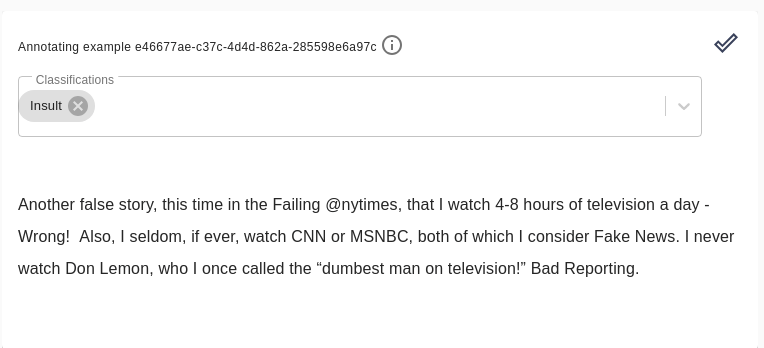

## Validating Entities
We saw how we can use regular expressions to capture entities in the text, such as People and Companies. However, our regex were not always precise, since we used naive concepts such as proper nouns. Validating them with humans has two benefits. First, it augments the human, helping them work faster. Second, the resulting labels are generated by a process that is more sophisticated then a regular expression. That means that when we use these labels, we can expect the model to learn something "deeper" then a regex. 

In LightTag, validating regexes comes in three flavors. Search, Suggestions and Resolution

### Search
In search mode, LightTag let's you and your team use regular expressions to search an entire dataset. We use advanced indexing techniques to make the regex search fast, regardless of language. When you search, we'll filter down the dataset to documents that match, and highlight the areas your regex hit. You can then annotate all or part of that span, and specify the type. 
Here is that process on the bible for the regex
```
[A-Z][a-z]+ [a-z]+ed
```
![./labelWithRegex.gif](./labelWithRegex.gif)

### Suggestion

In suggestion mode, we'll show the output of a regex (or anything else) as a pre-annotation to your annotators. They then are tasked with accepting or rejecting the suggestions and adding anything missing
![./suggestions.gif](./suggestions.gif)

### Review

In review mode, we'll cycle through any suggestion made by a regex or other model, as well as pre existing human annotations. In this mode, annotators validate that an annotation is correct and resolve conflicts if they exist
![./conflictRes.png](./conflictRes.png)

